In [1]:
import numpy as np
import xarray as xr
import scipy.stats as st
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import requests
import os,errno
import sys
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER,LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
import datetime as dt
import pandas as pd
import time
import urllib.request
import metpy.calc as mpcalc
import salem
import scipy.optimize as opt
import warnings
import geopy.distance
import matplotlib as mpl
from scipy.spatial import ConvexHull

from scipy.ndimage.measurements import label
from scipy.ndimage import binary_dilation

warnings.filterwarnings('ignore')

dir_data='/Users/ahenny/'
dir3='/Volumes/My Passport/'
dir2='/Volumes/Extreme Pro/'

/var/folders/6s/v2ptr27x1537n4_9dh_x4n0h0000gq/T/ipykernel_3780/3995050393.py:24: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label


In [2]:
ds=xr.open_dataset(dir_data+'time_series_simple_era5.nc')
areas_list_era5_fixed=ds['area_list_era5_fixed'].values.tolist()

percent=0.5

q1_era5_fixed=float(sum(areas_list_era5_fixed))/float(len(areas_list_era5_fixed))*percent
test=[x for x in areas_list_era5_fixed if x<q1_era5_fixed]
print(test)

[]


In [11]:
ds=xr.open_dataset(dir2+'merra2_gridareas.nc')
areas=ds['cell_area']/1e6

means_list=[]
means_list_all=[]
areas_list1=[]
yrs=np.arange(2014,2024,1)

bins=np.arange(0,1520,20)
arrays_sel=np.zeros((len(bins)))
arrays_all=np.zeros((len(bins)))

for i in range(len(yrs)):
    year=yrs[i]
    print(year)
    
    ds=xr.open_dataset(dir2+'era_5_ivtinterp_'+str(year)+'.nc')
    ivt=ds['ivt'][:,:,:]
    
    ds=xr.open_dataset(dir2+'era5.ar.labels.model.'+str(year)+'.nc')
    labeled=ds['ar_labeled']
    #land_mask_interp=land_mask.interp_like(labeled[0,:,:])
    #labeled=labeled.where(land_mask_interp>=0.5)
    binary=labeled/labeled
    
    ivt['lon']=labeled.lon.values 
    ivt['lat']=labeled.lat.values
    ivt['time']=labeled.time.values
    
    areas['lat']=labeled.lat.values
    areas['lon']=labeled.lon.values
    
    var_sel=ivt.where(binary==1).transpose('time','lat','lon')
    areas_sel=areas.where(binary==1).transpose('time','lat','lon')
    var_list=var_sel.values.ravel()
    areas_list=areas_sel.values.ravel()
    var_list=var_list[~np.isnan(var_list)]
    area_list=areas_list[~np.isnan(areas_list)]
    zipped=list(zip(area_list,var_list))
    sort=sorted(zipped,key=lambda x:x[1])
    sum_area=0
    j=0
    
    while sum_area<q1_era5_fixed:
        sum_area=sum_area+sort[-1*(j+1)][0]
        j=j+1
        index_final=j
    
    threshold=sort[-1*index_final][1]
    var_filter=var_sel.where(var_sel>=threshold)
    
    #########
    
    for j in range(len(bins)-1):
        print(j)
        var_filter_sel=var_filter.where(bins[j]<=var_filter)
        var_filter_sel=var_filter_sel.where(var_filter_sel<bins[j+1])
        test=var_filter_sel/var_filter_sel
        test=test.sum(dim='time',skipna=True)
        test=areas*test
        test=test.sum().values.tolist()
        arrays_sel[j]=arrays_sel[j]+test
        
        
        var_filter_sel=var_sel.where(bins[j]<=var_sel)
        var_filter_sel=var_filter_sel.where(var_filter_sel<bins[j+1])
        test=var_filter_sel/var_filter_sel
        test=test.sum(dim='time',skipna=True)
        test=areas*test
        test=test.sum().values.tolist()
        arrays_all[j]=arrays_all[j]+test
    
    
    #########
    
    weights=np.cos(np.deg2rad(var_sel.lat))
    weighted=var_filter.weighted(weights)
    var_mean=weighted.mean().values.tolist()
    print(var_mean)
    
    weighted=var_sel.weighted(weights)
    var_mean1=weighted.mean().values.tolist()
    print(var_mean1)
    
    area1=areas.where(binary==1)
    area1=area1.sum().values.tolist()
    
    means_list.append(var_mean)
    means_list_all.append(var_mean1)
    areas_list1.append(area1)

2014
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
619.2076692908734
481.9563056358638
2015
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
627.1585983731934
485.06820697319813
2016
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
641.6903479835046
487.85163214170547
2017
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
639.186644

In [7]:
print(arrays_all)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.88480748e+09
 4.54651501e+09 4.15750536e+09 3.76315805e+09 3.39387914e+09
 3.04744181e+09 2.73824930e+09 2.45048823e+09 2.20571630e+09
 1.97837594e+09 1.77733989e+09 1.59261975e+09 1.42816457e+09
 1.28228502e+09 1.15007092e+09 1.03384187e+09 9.29316379e+08
 8.35861135e+08 7.45244770e+08 6.71717343e+08 6.03407886e+08
 5.37430997e+08 4.83646856e+08 4.33118304e+08 3.86759544e+08
 3.46037533e+08 3.07173197e+08 2.72364396e+08 2.43498318e+08
 2.15873155e+08 1.92071908e+08 1.71510735e+08 1.52574534e+08
 1.34427062e+08 1.18173080e+08 1.06269529e+08 9.30169471e+07
 8.11890735e+07 7.23660723e+07 6.47008590e+07 5.61550789e+07
 4.87107319e+07 4.30458147e+07 3.82099469e+07 3.39949950e+07
 2.95920676e+07 2.57134285e+07 2.33987142e+07 2.01316998e+07
 1.79845567e+07 1.559626

In [12]:
dk=xr.Dataset()
dk['arrays_all']=(('bins'),arrays_all)
dk['arrays_sel']=(('bins'),arrays_sel)
dk['means_list']=(('time'),means_list)
dk['means_list_all']=(('time'),means_list_all)
dk['areas_list']=(('time'),areas_list1)

dk.coords['bins']=bins
dk.coords['time']=yrs

dk.to_netcdf(dir_data+'era5fixed_ffa_schematic_end.nc',mode='w',format='NETCDF4')

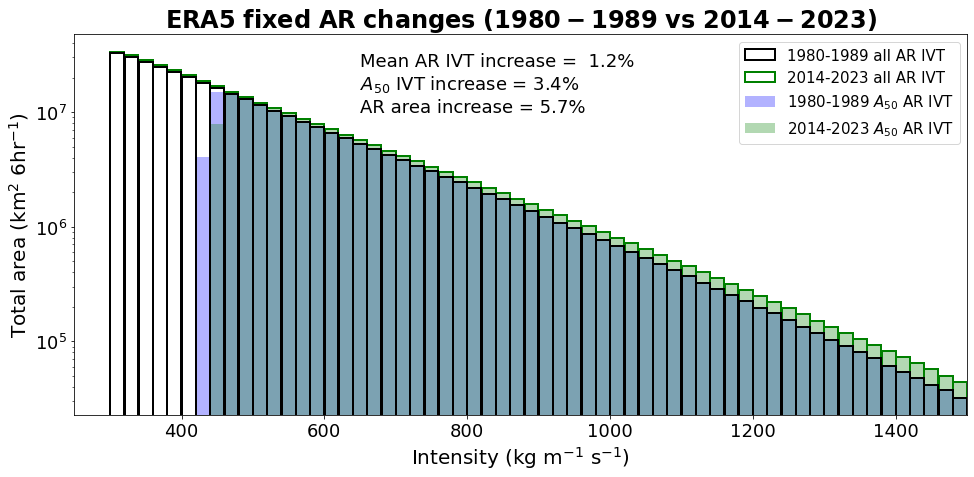

In [83]:
ds=xr.open_dataset(dir_data+'era5fixed_ffa_schematic_start.nc')
arrays_all=ds['arrays_all'].values.tolist()
arrays_sel=ds['arrays_sel'].values.tolist()
means_list=ds['means_list'].values.tolist()
means_list_all=ds['means_list_all'].values.tolist()
areas_list=ds['areas_list'].values.tolist()

area_sum=sum(areas_list)
mean1_all=[x*y for x,y in zip(means_list_all,areas_list)]
mean1_all=float(sum(mean1_all))/area_sum


mean1_sel=float(sum(means_list))/float(len(means_list))


ds=xr.open_dataset(dir_data+'era5fixed_ffa_schematic_end.nc')
arrays_all1=ds['arrays_all'].values.tolist()
arrays_sel1=ds['arrays_sel'].values.tolist()
means_list1=ds['means_list'].values.tolist()
means_list_all1=ds['means_list_all'].values.tolist()
areas_list1=ds['areas_list'].values.tolist()

area_sum1=sum(areas_list1)
mean2_all=[x*y for x,y in zip(means_list_all1,areas_list1)]
mean2_all=float(sum(mean2_all))/area_sum1

mean2_sel=float(sum(means_list1))/float(len(means_list1))

bins=np.arange(0,1520,20)
centers=[x+10 for x in bins[:]]
fig=plt.figure(figsize=(16,7))
ax=plt.subplot(1,1,1)
ax.set_xlim(250,1500)
ax.bar(centers,[x/365./4. for x in arrays_all],width=19.5,facecolor='None',edgecolor='k',linewidth=2,label='1980-1989 all AR IVT',zorder=200)

ax.bar(centers,[x/365./4. for x in arrays_all1],width=19.5,facecolor='None',edgecolor='g',linewidth=2,label='2014-2023 all AR IVT')

ax.bar(centers,[x/365./4. for x in arrays_sel],width=17.5,facecolor='b',edgecolor='None',alpha=0.3,label='1980-1989 $A_{50}$ AR IVT')

ax.bar(centers,[x/365./4. for x in arrays_sel1],width=17.5,facecolor='g',edgecolor='None',alpha=0.3,label='2014-2023 $A_{50}$ AR IVT')


test=[x/y-1. if y!=0 else np.nan for x,y in zip(arrays_all1,arrays_all)]



ax.tick_params(labelsize=18)
ax.set_xlabel('Intensity (kg m$^{-1}$ s$^{-1}$)',fontsize=20)
ax.set_ylabel('Total area (km$^{2}$ 6hr$^{-1}$)',fontsize=20)
ax.set_title(r'$\bf{ERA5}$'+' '+r'$\bf{fixed}$'+' '+r'$\bf{AR}$'+' '+r'$\bf{changes}$'+' '+r'$\bf{(1980-1989}$'+' '+r'$\bf{vs}$'+' '+r'$\bf{2014-2023)}$',fontsize=24,pad=5)

ax.text(650,2.5e7,'Mean AR IVT increase =  '+str(round((mean2_all/mean1_all-1)*100.,1))+'%',fontsize=18)
#ax.text(800,9,'2014-2023 Mean AR IVT = '+str(round(mean2_all,1)),fontsize=20)

ax.text(650,16e6,'$A_{50}$ IVT increase = '+str(round((mean2_sel/mean1_sel-1)*100.,1))+'%',fontsize=18)

ax.text(650,10e6,'AR area increase = '+str(round((area_sum1/area_sum-1)*100.,1))+'%',fontsize=18)

plt.legend(loc='upper right',fontsize=15)
plt.yscale('log')
plt.show()


In [84]:
fig.savefig(dir_data+'fixed_frequency_schematic.png',dpi=200)

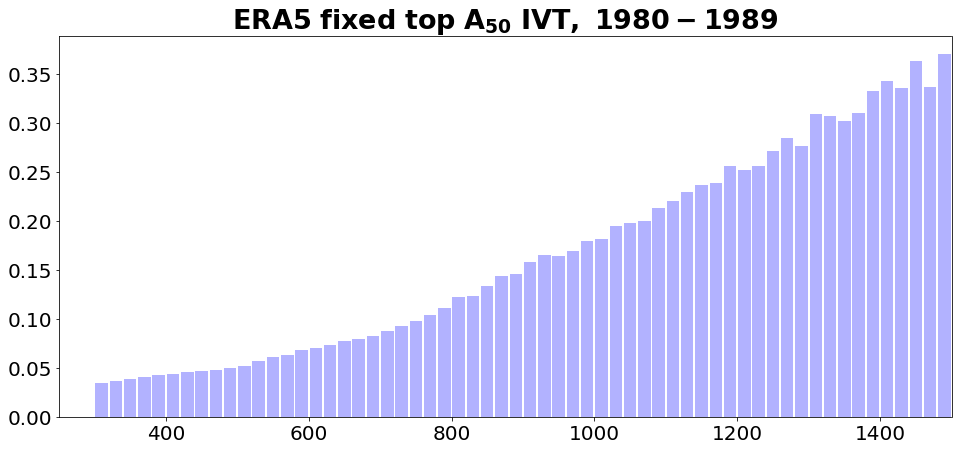

In [46]:
ds=xr.open_dataset(dir_data+'era5fixed_ffa_schematic_start.nc')
arrays_all=ds['arrays_all'].values.tolist()
arrays_sel=ds['arrays_sel'].values.tolist()
means_list=ds['means_list'].values.tolist()
means_list_all=ds['means_list_all'].values.tolist()
areas_list=ds['areas_list'].values.tolist()


ds=xr.open_dataset(dir_data+'era5fixed_ffa_schematic_end.nc')
arrays_all1=ds['arrays_all'].values.tolist()
arrays_sel1=ds['arrays_sel'].values.tolist()
means_list1=ds['means_list'].values.tolist()
means_list_all1=ds['means_list_all'].values.tolist()
areas_list1=ds['areas_list'].values.tolist()


test=[x/y-1. if y!=0 else np.nan for x,y in zip(arrays_all1,arrays_all)]

bins=np.arange(0,1520,20)
centers=[x+10 for x in bins[:]]
fig=plt.figure(figsize=(16,7))
ax=plt.subplot(1,1,1)
ax.set_xlim(250,1500)

ax.bar(centers,test,width=17.5,facecolor='b',edgecolor='None',alpha=0.3)


ax.tick_params(labelsize=20)
#ax.set_xlabel('Intensity (kg m$^{-1}$ s$^{-1}$)',fontsize=22)
#ax.set_ylabel('Total area (10$^{7}$ km$^{2}$ day$^{-1}$)',fontsize=22)
ax.set_title(r'$\bf{ERA5}$'+' '+r'$\bf{fixed}$'+' '+r'$\bf{top}$'+' '+r'$\bf{A_{50}}$'+' '+r'$\bf{IVT,}$'+' '+r'$\bf{1980-1989}$',fontsize=27,pad=5)
plt.show()